# Example notebook showing how to run the CASTOR grism ETC

## WARNING: This is the very first version (0.0.1) of the grism ETC, and improvement is still underway. The current version demonstrates how to use the tool but changes in the specification files or the tool itself may occur and current results should be taken with caution.

# 0 - imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ETC_grism_dev
from ETC_grism_dev import background
from ETC_grism_dev import spectrum
from ETC_grism_dev import disperser

# 1 - Create the direct image source

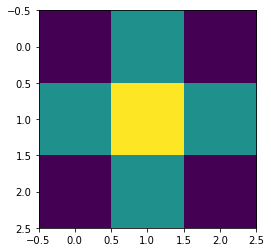

In [2]:
#Here we create a dummy source, but could be generated from a sersic profile or taken from the imaging castor ETC.
source_image = np.array([[0,1,0],[1,2,1],[0,1,0]])
#The source image can be in relative fluxes, but pixels must be 0.1arcsec across.

#we also need an aperture to know which pixels will be dispersed with the grism on the detector.
source_seg = source_image > 0

plt.figure()
plt.imshow(source_image)

# 2 - Create the source spectrum

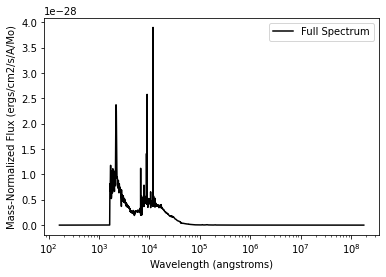

TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4074277929769683e-17 9.0479977259673e-29 155551298265.44067
NORM_FLAM, NORM_FNU, NORM_MAG:  1.4074277929769683e-17 2.2908676527677887 22.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4074277929769683e-17 2.2908676527677887 23


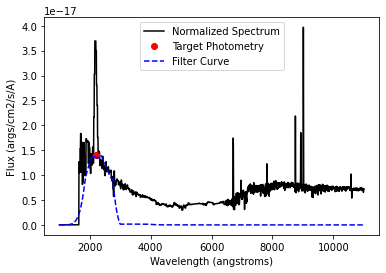

0

In [60]:
#Here we generate an FSPS spectrum.
#The user can also generate its own spectrum that can be then passed to the spectrum object with:
#spectrum.spectrum = (wave, flux)
#where 'wave' is the 1D wavelength array in angstroms, and 'flux' is the 1D flux array in ergs/cm2/s/A.

#If running FSPS for the first time, this might take a little bit of time.
source_redshift = 0.8 #If a redshift other than 0 is provided, then spectrum is automatically redshifted.
fsps_params_dict = {"tau": 1, "logzsol": 0, "dust2": 0.2}
fsps_age = 5 #Gyrs
spectrum.spectrum_from_fsps(spectrum, fsps_params_dict=fsps_params_dict, fsps_age=fsps_age, redshift=source_redshift, check=True)

#Normalize spectrum to a given mag in one of the CASTOR filters (uv, u or g).
source_mag = 23
filter_channel = "uv"
spectrum.normalize_spectrum(spectrum, magnitude=source_mag, filter_channel=filter_channel, check=True)


# 3 - Disperse the source spectrum with the appropriate grism ("uv" or "u")

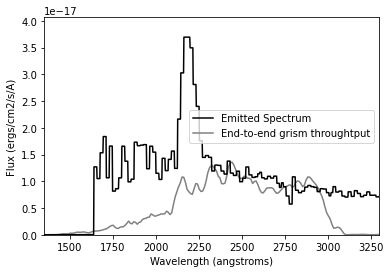

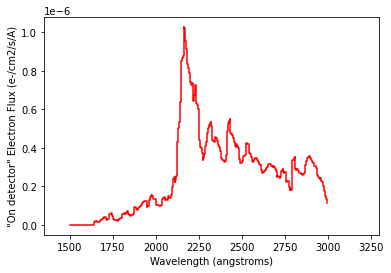

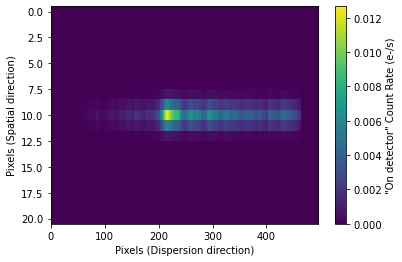

0

In [61]:
#The spectrum is dispersed pixel by pixel, only pixels within the source_disperse_region are dispersed.
source_spectrum = spectrum.spectrum
grism_channel = "uv" #disperse the spectrum with the uv-band grism.

#disperse
disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)


# 4 - Create the (count rate) sky background

In [62]:
#The user can specify their own zodical, earthshine and geocoronal.
#By default this uses the ones also provided in the imaging ETC.
#To use your own background, 'user_zodi', 'user_earthshine', and 'user_geo' should be a path to the approriate files,
#in the same format and structure as the default ones; and 'default_sky' should be set to False.
background.recompute_sky_background(background, default_sky=True, user_zodi=None, user_earthshine=None, user_geo=None)


0

# 5 - Observe source for X seconds.

In [63]:
#Create first the noiseless integrated grism spectrum.
exposure_time = 1000 #in seconds
disperser.expose(disperser, exposure_time=exposure_time)
#The 2D exposure (in counts [e-]), is in: 'disperser.integrated_grism_box_count'


#Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)
Nreads = 1 #number of read-outs during total exposition.
disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
#The 2D total noise is in: 'disperser.grism_noise_total'


0

# 6 - Access spectrum and noise data to get an SNR

Text(0.5, 0, 'Pixels (Dispersion direction)')

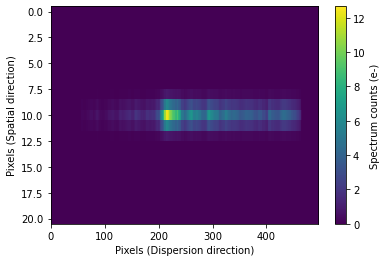

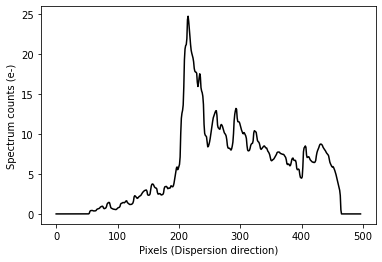

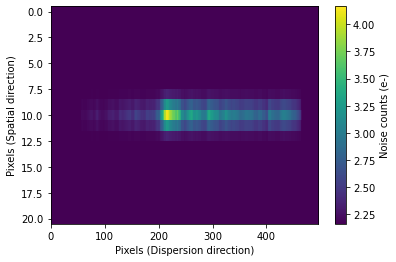

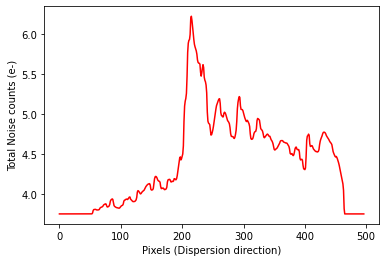

In [64]:
#Show noisless spectrum (in total counts)
#The noiseless data is in: disperser.integrated_grism_box_count
plt.imshow(disperser.integrated_grism_box_count, aspect="auto", interpolation="none")
plt.colorbar(label='Spectrum counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')
#1D spectrum (extracted within spatial extent of source image defined in step 1)
plt.figure()
box_center = int((disperser.integrated_grism_box_count.shape[0]-1) / 2)
half_source_size = int((source_image.shape[0]-1) / 2)
grism_1d = np.sum(disperser.integrated_grism_box_count[box_center-half_source_size:box_center+half_source_size+1,:],
                  axis=0)
grism_1d_x = np.arange(0,len(grism_1d), 1)
plt.plot(grism_1d_x, grism_1d, '-k')
plt.ylabel('Spectrum counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')

#Show signal+sky+detector noise (in total counts)
#The total signal+sky+detector noise is in disperser.grism_noise_total
plt.figure()
plt.imshow(disperser.grism_noise_total, aspect="auto", interpolation="none")
plt.colorbar(label='Noise counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')
#1D
#The 1D noise is shown here as the error sum at each wavelength along spatial axis.
#Also extracted within spatial extent of source image
plt.figure()
totnoise_1d = np.sqrt(np.sum(disperser.grism_noise_total[box_center-half_source_size:box_center+half_source_size+1,:]**2,
                             axis=0))
plt.plot(grism_1d_x, totnoise_1d, '-r')
plt.ylabel('Total Noise counts (e-)')
plt.xlabel('Pixels (Dispersion direction)')


Text(0.5, 0, 'Pixels (Dispersion direction)')

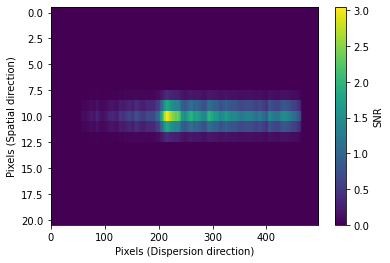

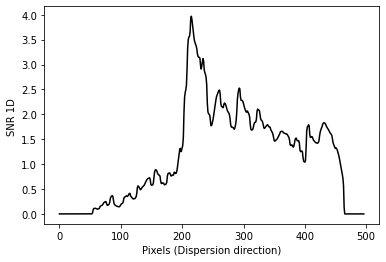

In [65]:
#Show SNR per resolution element
plt.imshow(disperser.integrated_grism_box_count/disperser.grism_noise_total, aspect="auto", interpolation="none")
plt.colorbar(label='SNR')
plt.xlabel('Pixels (Dispersion direction)')
plt.ylabel('Pixels (Spatial direction)')


#Show as 1D
#1D noise taken here as the error sum at each wavelength along spatial axis.
#Extracted within spatial extent of source image
plt.figure()
sum_signal_1d = np.sum(disperser.integrated_grism_box_count[box_center-half_source_size:box_center+half_source_size+1,:], 
                       axis=0)
quad_error_1d = np.sqrt(np.sum(disperser.grism_noise_total[box_center-half_source_size:box_center+half_source_size+1,:]**2, 
                               axis=0))
snr_1d = sum_signal_1d / quad_error_1d
plt.plot(grism_1d_x, snr_1d, '-k')
plt.ylabel('SNR 1D ')
plt.xlabel('Pixels (Dispersion direction)')
